# Make  spectra average
=======================================



- Author Sylvie Dagoret-Campagne
- Creation date Friday 5th 2016


## Import packages
-------------------------

In [237]:
%config InlineBackend.rc = {}
import matplotlib
matplotlib.rc_file("../templates/matplotlibrc")


%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits

import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.0.1


In [238]:
def smooth(x,window_len=11,window='hanning'):
    """
    smooth the data using a window with requested size.     
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
     (with the window size) in both ends so that transient parts are minimized
     in the begining and end part of the output signal.     
     input:
     x: the input signal 
     window_len: the dimension of the smoothing window; should be an odd integer
     window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman
     flat window will produce a moving average smoothing.

     output:
        the smoothed signal         
        example:
 
         t=linspace(-2,2,0.1)
         x=sin(t)+randn(len(t))*0.1
         y=smooth(x)
         
         see also: 
           
         numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
           scipy.signal.lfilter
    
           TODO: the window parameter could be the window itself if an array instead of a string
           NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
       """ 
      
    if x.ndim != 1:
        raise ValueError, "smooth only accepts 1 dimension arrays."
 
    if x.size < window_len:
        raise ValueError, "Input vector needs to be bigger than window size."
 
    if window_len<3:
        return x
   
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"
       
  
    s=np.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')
     
    y=np.convolve(w/w.sum(),s,mode='valid')
    return y    

In [239]:
from scipy import stats 
from scipy import ndimage
import os
from datetime import datetime, timedelta

In [240]:
now=datetime.utcnow()  # choose UTC time
datestr=str(now)
print 'standard date format for the analysis :',datestr
#  want the following format '2016-05-10T11:55:27.267'
date_of_analysis=now.strftime('%Y-%m-%dT%H:%M:%S')
print 'fits date format for the analysis : ',date_of_analysis

standard date format for the analysis : 2016-07-08 15:26:56.784648
fits date format for the analysis :  2016-07-08T15:26:56


## Few definitions
-----------------------

- file index
- object name
- filename
- path

In [241]:
fileindex_start=103;  # file number
fileindex_stop=112;
fileindexes=np.arange(fileindex_start,fileindex_stop+1)

In [242]:
object_name='HD158485_grat_' # object name

In [243]:
#path
path_spectrum=path='../MyReduction_2016_05_11/HD158485_grat'+'_spectra'   # path where is the spectra

In [244]:
file_list=[os.path.join(path_spectrum,'dataspec_'+object_name+str(filenum)+'.fits' ) for filenum in fileindexes]

In [245]:
file_list

['../MyReduction_2016_05_11/HD158485_grat_spectra/dataspec_HD158485_grat_103.fits',
 '../MyReduction_2016_05_11/HD158485_grat_spectra/dataspec_HD158485_grat_104.fits',
 '../MyReduction_2016_05_11/HD158485_grat_spectra/dataspec_HD158485_grat_105.fits',
 '../MyReduction_2016_05_11/HD158485_grat_spectra/dataspec_HD158485_grat_106.fits',
 '../MyReduction_2016_05_11/HD158485_grat_spectra/dataspec_HD158485_grat_107.fits',
 '../MyReduction_2016_05_11/HD158485_grat_spectra/dataspec_HD158485_grat_108.fits',
 '../MyReduction_2016_05_11/HD158485_grat_spectra/dataspec_HD158485_grat_109.fits',
 '../MyReduction_2016_05_11/HD158485_grat_spectra/dataspec_HD158485_grat_110.fits',
 '../MyReduction_2016_05_11/HD158485_grat_spectra/dataspec_HD158485_grat_111.fits',
 '../MyReduction_2016_05_11/HD158485_grat_spectra/dataspec_HD158485_grat_112.fits']

In [246]:
NBFILES=len(file_list)

In [247]:
print NBFILES

10


## Read the files
---------------------------


In [248]:
spectra_list = []
wavelength_list = []
obspred_list = []
wavelengthobspred_list = []
atm_list= []

### A) Open the files

In [249]:
for thefile in file_list:
    hdulist=fits.open(thefile) 
    # spectra
    table_data1=hdulist[1].data  # get only the data not the prediction
    specdata_wavelength=table_data1.field('WAVELENGTH')
    specdata_flux=table_data1.field('SPECTRUMDATA')
    
    spectra_list.append(specdata_flux)
    wavelength_list.append(specdata_wavelength)
    # prediction
    table_data2=hdulist[2].data    
    wavelength_sed=table_data2.field('WAVELENGTH')
    flux_sed=table_data2.field('SEDcalspec')
    flux_sedccd=table_data2.field('SEDxQE')
    flux_sedccdatm=table_data2.field('SEDxQExATM')
    flux_sedccdatmopt=table_data2.field('SEDxQExATMxTopt')
    atm=np.where(flux_sedccd>0,flux_sedccdatm/flux_sedccd,0)
    obspred_list.append(flux_sedccdatmopt)
    wavelengthobspred_list.append(wavelength_sed)
    atm_list.append(atm)
    
    hdulist.close()

/Users/dagoret-campagnesylvie/anaconda/envs/pyastrophys/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in divide


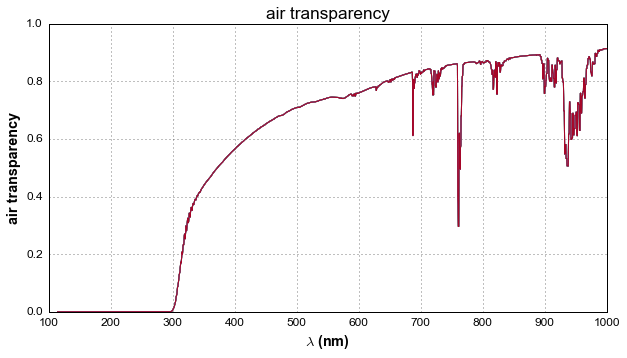

In [250]:
plt.figure(figsize=(10,5))
for idx,atm in enumerate(atm_list):
    plt.plot(wavelengthobspred_list[idx],atm_list[idx])
plt.title('air transparency')
plt.xlabel('$\lambda$ (nm)')
plt.ylabel('air transparency')

### Combine the predictions

In [251]:
TableLength = []
for obsp in obspred_list:
    TableLength.append(obsp.shape[0])
    
print 'min Table Length = ' , min(TableLength)
print 'max Table Length = ' , max(TableLength)

NBWLBINSPRED=min(TableLength)

min Table Length =  3729
max Table Length =  3729


In [252]:
specpred_array=np.zeros((NBFILES,NBWLBINSPRED))
wavelengthpred_array=np.zeros((NBFILES,NBWLBINSPRED))

In [253]:
for idx,obspred in enumerate(obspred_list):
    specpred_array[idx,:]=obspred[0:NBWLBINSPRED]
    wavelengthpred_array[idx,:]=wavelengthobspred_list[idx][0:NBWLBINSPRED]

In [254]:
combined_obspred=np.average(specpred_array,axis=0)
combined_obspred_rms=np.std(specpred_array,axis=0)
combined_wavelengthPRED=np.average(wavelengthpred_array,axis=0)

### Smooth the predicted response to simulate finite wavelength resolution

In [255]:
smooth_window=61
smoothed_obspred=smooth(combined_obspred,window_len=smooth_window,window='hanning')

In [256]:
combined_obspred.shape

(3729,)

In [257]:
smoothed_obspred.shape

(3789,)

In [258]:
smoothed_obspred.shape[0]-combined_obspred.shape[0]

60

In [259]:

smoothed_obspred2=smoothed_obspred[smooth_window/2: smoothed_obspred.shape[0]-smooth_window/2]

In [260]:
smoothed_obspred2.shape

(3729,)

In [261]:
(combined_wavelengthPRED[1]- combined_wavelengthPRED[0])*smooth_window

3.561187744140625

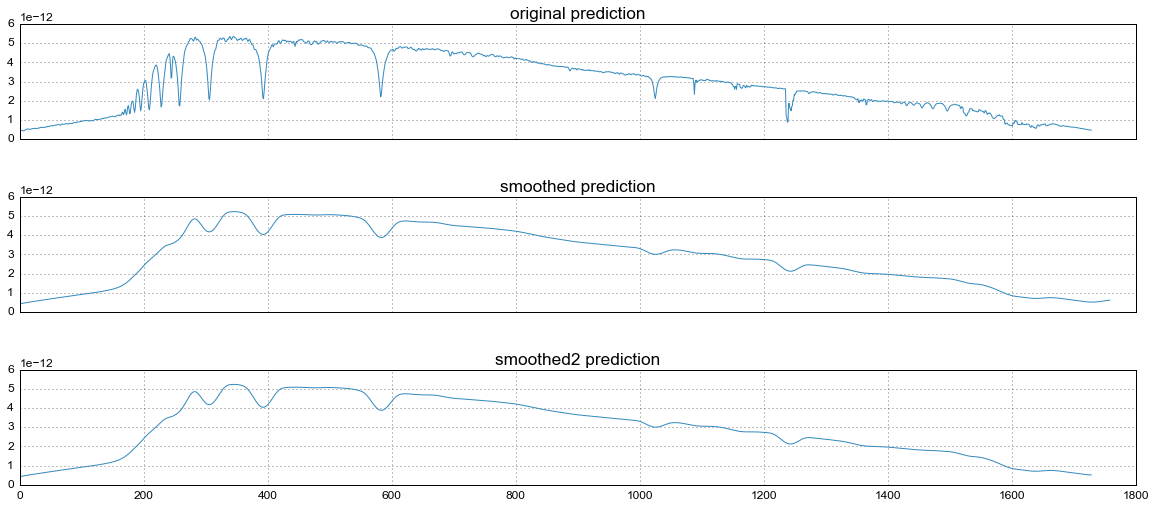

In [262]:
# Two subplots, the axes array is 1-d
f, axarr = plt.subplots(3, sharex=True,figsize=(20,8))

axarr[0].plot(combined_obspred[2000:4000])
axarr[0].set_title('original prediction')
axarr[1].plot(smoothed_obspred[2000+smooth_window/2:4000])
axarr[1].set_title('smoothed prediction')
axarr[2].plot(smoothed_obspred2[2000:4000])
axarr[2].set_title('smoothed2 prediction')

### combine the spectra 

In [263]:
TableLength = []
for spectrum in spectra_list:
    TableLength.append(spectrum.shape[0])

In [264]:
print 'min Table Length = ' , min(TableLength)
print 'max Table Length = ' , max(TableLength)

min Table Length =  2494
max Table Length =  2496


In [265]:
NBWLBINS=min(TableLength)

In [266]:
specdata_array=np.zeros((NBFILES,NBWLBINS))
wavelength_array=np.zeros((NBFILES,NBWLBINS))



In [267]:
for idx,spectrum in enumerate(spectra_list):
    spec=np.array(spectrum)
    specdata_array[idx,:]=spec[0:NBWLBINS]
    wavelength_array[idx,:]=wavelength_list[idx][0:NBWLBINS]

In [268]:
combined_spectra=np.average(specdata_array,axis=0)
combined_spectra_rms=np.std(specdata_array,axis=0)
combined_wavelength=np.average(wavelength_array,axis=0)

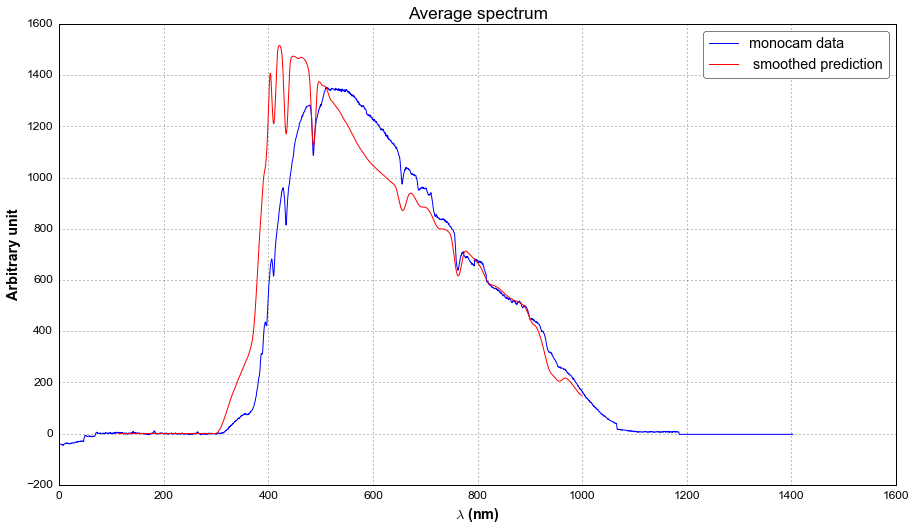

In [271]:
plt.figure(figsize=(15.,8.))
plt.plot(combined_wavelength,combined_spectra,'b',label='monocam data')
#plt.plot(combined_wavelengthPRED,combined_obspred*3e14,'r',label=' prediction')
plt.plot(combined_wavelengthPRED,smoothed_obspred2*2.9e14,'r',label=' smoothed prediction')

plt.title('Average spectrum')
plt.xlabel('$\lambda$ (nm)')
plt.ylabel('Arbitrary unit')
plt.legend()
plt.show()

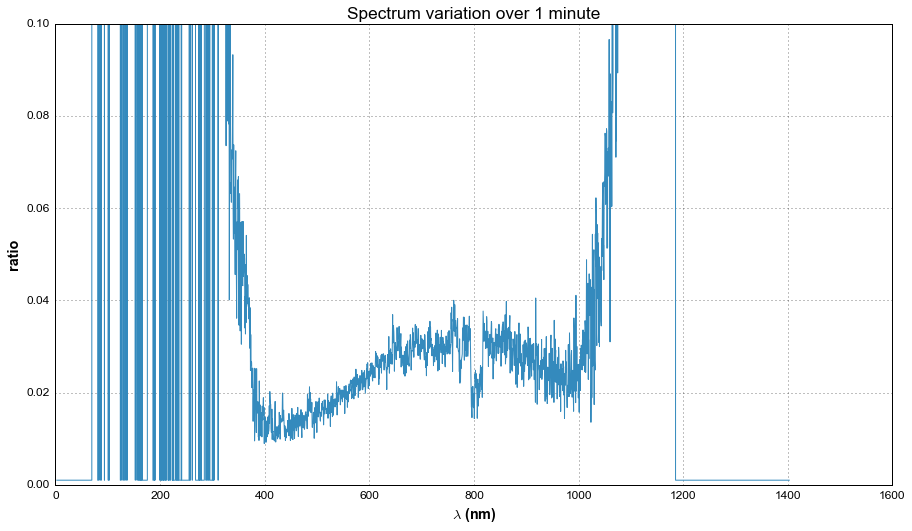

In [270]:
plt.figure(figsize=(15.,8.))
ratio=np.where(combined_spectra>0, combined_spectra_rms/combined_spectra,0.001)
plt.plot(combined_wavelength,ratio)
plt.ylim(0.,0.1)
plt.title('Spectrum variation over 1 minute')
plt.xlabel('$\lambda$ (nm)')
plt.ylabel('ratio')